In [1]:
pip install -e ../../STREAM2/

Obtaining file:///mnt/c/Users/jobac/Desktop/all/git/STREAM2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from comparison_utils import *
import scipy
from mpl_toolkits.mplot3d import Axes3D
import stream2 as st2
%load_ext rpy2.ipython

def load_slingshot(res_path,slingshot_ncenters):
    %R -i res_path -i slingshot_ncenters
    %R path <- slingshot_ncenters
    curves_gmm = %R readRDS(paste(res_path,'slingshot_curves_gmm.rds',sep='_'))
    curves_kmeans = %R readRDS(paste(res_path,'slingshot_curves_kmeans',path,'.rds',sep='_'))
    cl1 = %R readRDS(paste(res_path,'slingshot_gmm.rds',sep='_'))
    cl2 = %R readRDS(paste(res_path,'slingshot_kmeans',path,'.rds',sep='_'))
    
    all_lineages = {}
    for n,curve in zip(['kmeans','GMM'],[curves_kmeans,curves_gmm]):
        lineages = dict(curve.items())
        for k,v in lineages.items():
            lineages[k] = dict(v.items())
            for k2,v2 in lineages[k].items():
                lineages[k][k2]=np.array(lineages[k][k2])
            lineages[k]['s']=lineages[k]['s'][lineages[k]['ord']-1]
        all_lineages[n]=lineages

    all_lineages['kmeans'] = [v['s'] for k,v in all_lineages['kmeans'].items()]
    all_lineages['GMM'] = [v['s'] for k,v in all_lineages['GMM'].items()]
    return all_lineages

def load_monocle(res_path,mcle_ncenters ,mcle_sigma,mcle_gamma):
    %R -i res_path -i mcle_ncenters -i mcle_sigma -i mcle_gamma
    path = %R path <- paste(mcle_ncenters,mcle_sigma,mcle_gamma,sep='_')
    path=path[0]
    nodep = %R readRDS(paste(res_path,'monocle_dp_mst',path,'.rds',sep='_'))
    nodep = np.array(nodep.T)
    stree = scipy.io.mmread(res_path+f'_monocle_stree_{path}_.mm')
    edges = np.argwhere(np.triu(stree.todense()))
    clus = %R readRDS(paste(res_path,'monocle_clus',path,'.rds',sep='_'))
    partitions = np.array(np.array(clus)[1])
    clusters = np.array(np.array(clus)[2])
    return nodep, stree, edges, partitions, clusters

def run_monocle_slingshot_tuned(data_path, res_path, slingshot_ncenters = 50,mcle_ncenters = 50,mcle_sigma = 0.01,mcle_gamma = 0.5,mcle_eps = 1e-05):
    ! /home/jo/anaconda3/envs/qz_monocle3/bin/Rscript run_monocle_slingshot_tuned.R $data_path $slingshot_ncenters $mcle_ncenters $mcle_sigma $mcle_gamma $mcle_eps $res_path
    
    lineages = load_slingshot(res_path,slingshot_ncenters)
    nodep, stree, edges, partitions, clusters = load_monocle(res_path,mcle_ncenters ,mcle_sigma ,mcle_gamma)
    return lineages, nodep, stree, edges, partitions, clusters

def labels_to_color(labels):
    '''Turn a list of labels into a list of colors'''
    import seaborn as sns
    import matplotlib.patches as mpatches
    unique_labels = np.unique(labels)
    colors = sns.color_palette('hls', len(unique_labels))

    # Associate each sample with a color indicating its type
    idx = np.zeros(len(labels)).astype(int)
    legend = []
    for i in range(len(unique_labels)):
        idx[labels == unique_labels[i]] = i
        legend.append(mpatches.Patch(color=colors[i], label=unique_labels[i]))
                       
    col = [colors[i] for i in idx]
    return col, legend, unique_labels

def init_subplot(d1=0,d2=2):
    ax = next(axs)
    ax.set_xlabel(f'UMAP{d1+1}',labelpad=5,fontsize=25)
    ax.set_ylabel(f'UMAP{d2+1}',labelpad=5,fontsize=25)
    ax.locator_params(axis='x',nbins=4)
    ax.locator_params(axis='y',nbins=4)
    ax.tick_params(axis="x",pad=10)
    ax.tick_params(axis="y",pad=-1)
    _=ax.scatter(X_plot[:,d1],X_plot[:,d2],c=c_plot,s=15,alpha=.2)
    return ax,_

# Load data
We directly load processed data from Luo 2017 (without features; just the embedding)

Uncomment the second cell below if you wish to load the full data and recompute the embedding

In [1]:
adata=sc.read('../data/methylation/layers_promoter.h5ad')
adata.obsm['X_umap']=adata.obsm['X_dr']
data_path = "../data/methylation/umap.csv"
np.savetxt(data_path,adata.obsm['X_umap'].T.copy(),delimiter=',')
X = adata.obsm['X_umap']

In [4]:
## download data with all features from original manuscript link: https://zenodo.org/record/4292082
#adata_epi = sc.read('../../../STREAM2/notebooks/DNA_Luo_2017/DNA_Luo_2017/rawData/processed_promoter_CG_luo_et_al_nov2020_paper_resubmission.h5ad')
#adata = adata[np.isin(adata.obs['Neuron type'],['mL2/3', 'mL4', 'mL5-1', 'mL5-2','mL6-1','mL6-2'])].copy()
#
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)
#sc.pl.umap(adata,color='Neuron type')
#adata.obsm['X_dr']=adata.obsm['X_umap']

# Compute graphs


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

<ipython-input-1-246b30f24d6b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  partitions = np.array(np.array(clus)[1])
<ipython-input-1-246b30f24d6b>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters = np.array(np.array(clus)[2])


input data has shape 2278 (samples) x 2 (features)
time is Sun Jul 23 10:48:38 2023
commencing global pruning
Share of edges kept after Global Pruning 48.66 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 
size neighbor array in low-KNN in pca-space for visualization (2278, 5)
commencing community detection
time is Sun Jul 23 10:48:39 2023
59  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 50.8
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times


/home/jo/anaconda3/envs/c4/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


ended all multiprocesses, will retrieve and reshape
closeness  shortlist [0, 1, 5, 6, 8, 9, 10, 14, 16, 20, 23, 26, 27, 28, 32, 34, 35, 38, 39, 44, 45, 48]
betweeness shortlist [1, 4, 5, 6, 7, 8, 10, 11, 15, 16, 18, 20, 24, 26, 27, 28, 31, 32, 34, 35, 36, 38, 39, 42, 43, 44, 46, 48]
out degree shortlist [0, 1, 2, 4, 8, 9, 10, 11, 13, 14, 16, 20, 21, 26, 27, 28, 32, 34, 35, 36, 37, 38, 41, 42, 45, 48]
TS 0 had 2 or more neighboring terminal states, namely [9, 27, 32]  and so we removed, 27
TS 1 had 2 or more neighboring terminal states, namely [36, 38]  and so we removed, 36
TS 5 had 2 or more neighboring terminal states, namely [20, 44]  and so we removed, 5
TS 6 had 2 or more neighboring terminal states, namely [11, 48]  and so we removed, 11
TS 9 had 2 or more neighboring terminal states, namely [0, 20, 45]  and so we removed, 9
TS 10 had 2 or more neighboring terminal states, namely [14, 45]  and so we removed, 14
TS 16 had 2 or more neighboring terminal states, namely [26, 39]  and

/home/jo/anaconda3/envs/c4/lib/python3.8/site-packages/pyVIA/core.py:2902: RuntimeWarning: invalid value encountered in true_divide
  bp_array = bp_array / bp_array.sum(axis=1)[:, None]


number of components before pruning 1
percentage links trimmed from local pruning relative to start 25.6
percentage links trimmed from global pruning relative to start 52.1


/home/jo/anaconda3/envs/c4/lib/python3.8/site-packages/pyVIA/core.py:3127: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(


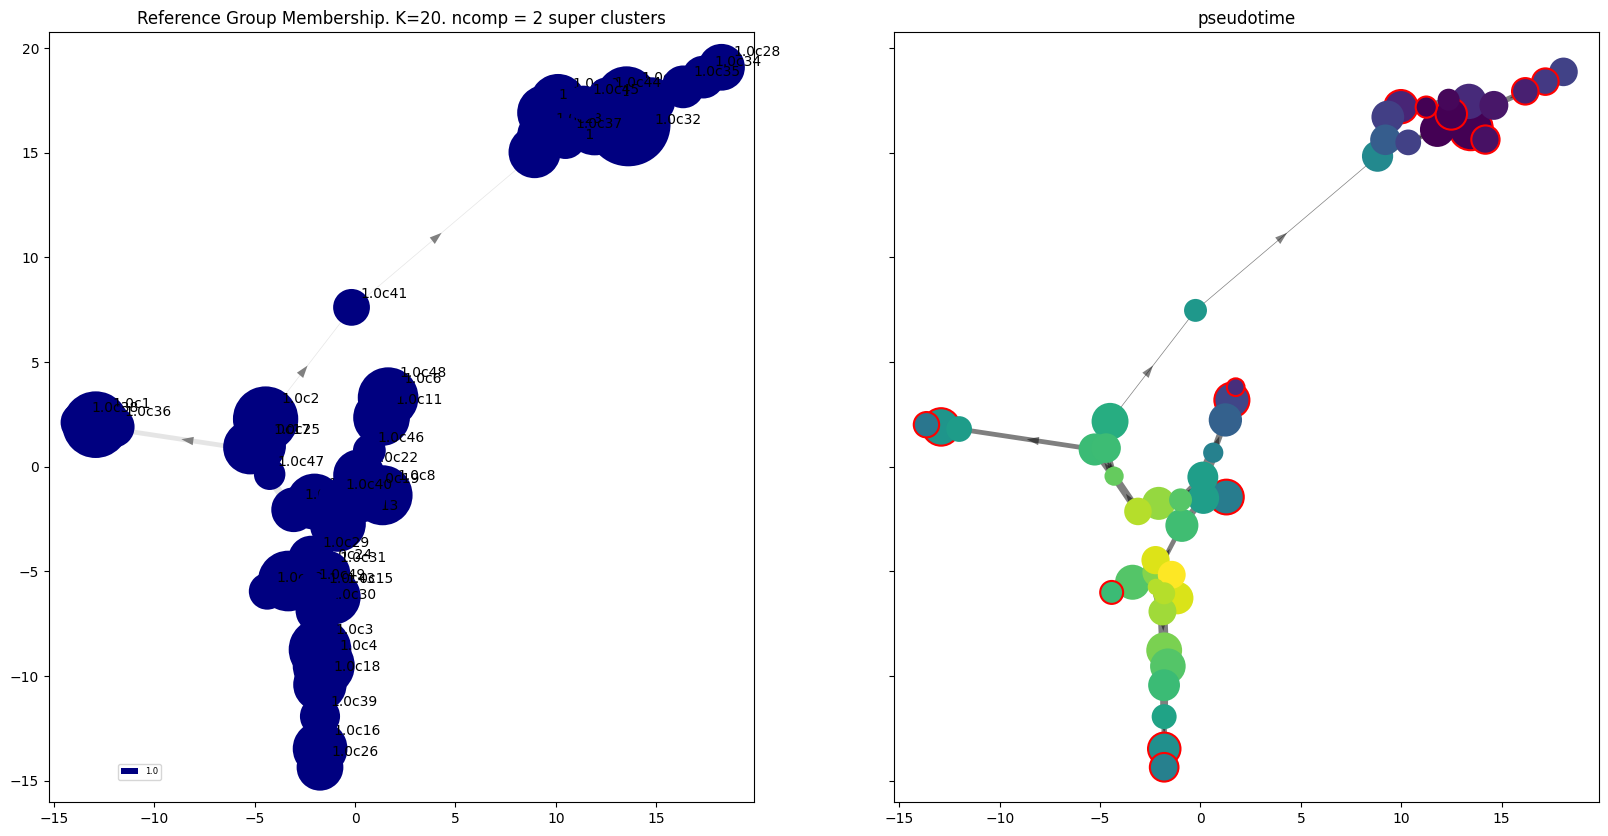

time elapsed 89.6 seconds
input data has shape 2278 (samples) x 2 (features)
time is Sun Jul 23 10:50:07 2023
commencing global pruning
Share of edges kept after Global Pruning 49.05 %
commencing community detection
time is Sun Jul 23 10:50:07 2023
59  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 50.4
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [0, 1, 6, 8, 10, 16, 20, 26, 32, 34, 35, 38, 42, 45, 48]
no sub cluster has majority made of super-cluster  0
terminal clus in this component [0, 11, 7, 8, 10, 15, 19, 28, 33, 36, 35, 38, 41, 45, 48]
final terminal clus [0, 11, 7, 8, 10, 15, 19, 28, 33, 36, 35, 38, 4

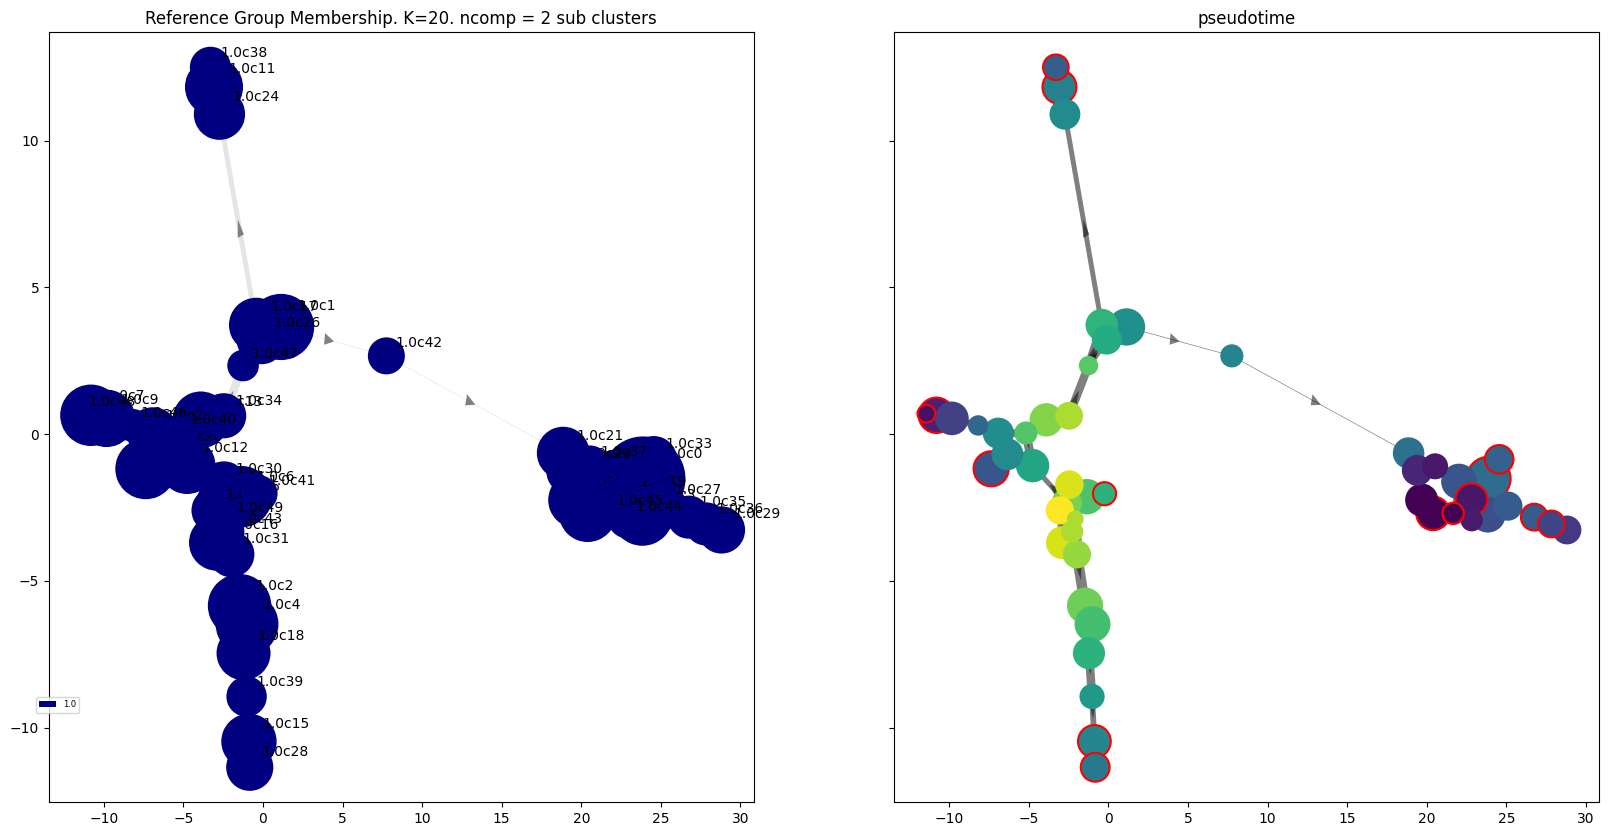

time elapsed 90.4 seconds
dict of terminal state pairs, Super: sub:  {0: 0, 1: 11, 6: 7, 8: 8, 10: 10, 16: 15, 20: 19, 26: 28, 32: 33, 34: 36, 35: 35, 38: 38, 42: 41, 45: 45, 48: 48}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 0 is a super terminal with sub_terminal cluster 0
super cluster 1 is a super terminal with sub_terminal cluster 11
super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 8 is a super terminal with sub_terminal cluster 8
super cluster 10 is a super terminal with sub_terminal cluster 10
super cluster 16 is a super terminal with sub_terminal cluster 15
super cluster 20 is a super terminal with sub_terminal cluster 19
super cluster 26 is a super terminal with sub_terminal cluster 28
super cluster 32 is a super terminal with sub_terminal cluster 33
super cluster 34 is a super terminal with sub_terminal cluster 36
super cluster 35 is a super terminal with sub_terminal cluster 35
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 42 is a super terminal with sub_terminal cluster 41
super cluster 45 is a super terminal with sub_terminal cluster 45
super cluster 48 is a super terminal with sub_terminal cluster 48


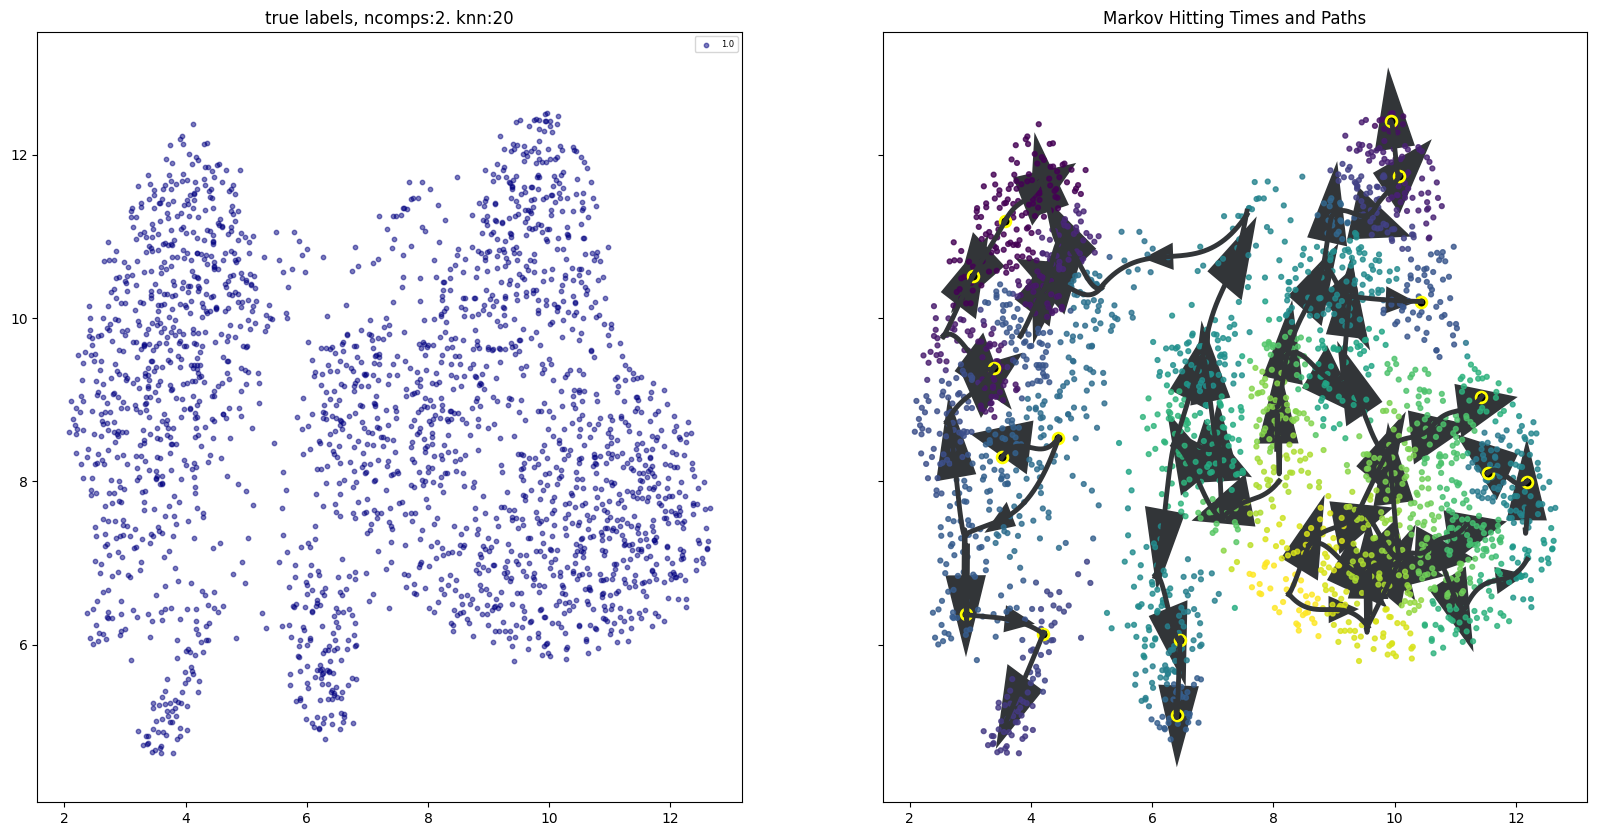

In [5]:
import os
if not 'R_outputs' in os.listdir('.'): 
    os.mkdir('R_outputs')
if not 'synthetic' in os.listdir('R_outputs'): 
    os.mkdir('R_outputs/methylation')

#default results
(slingshot_lineages, 
 mcle_nodep, mcle_stree, mcle_edges, 
 mcle_partitions, mcle_clusters) = run_monocle_slingshot_tuned(data_path, slingshot_ncenters = 50, 
                                                         mcle_ncenters = 50, mcle_sigma = 0.01, 
                                                         mcle_gamma = 0.5, mcle_eps = 1e-05,res_path='R_outputs/methylation/')

((via_out, via_projected_sc_pt, 
 (loci, c_edge, width_edge, pen_color, dot_size)),
 _,_) = run_VIA(X,X,labels=None,root_user = [0], v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, knn = 20,ncomps=2)

#((via_out_pca, via_projected_sc_pt_pca, 
# (loci_pca, c_edge_pca, width_edge_pca, pen_color_pca, dot_size_pca)),
# (via_out2_pca, via_projected_sc_pt2_pca,
# (loci2_pca, c_edge2_pca, width_edge2_pca, pen_color2_pca, dot_size2_pca)),
# (via_out3_pca, via_projected_sc_pt3_pca,
# (loci3_pca, c_edge3_pca, width_edge3_pca, pen_color3_pca, dot_size3_pca)),) = run_VIA(adata.obsm['X_pca'],X,labels=None,root_user = [0], 
#                                                            v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
#                                                            knn = 20,ncomps=20)

paga_nodep, paga_edges, paga_weights = run_paga(adata,X,resolution=1)

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


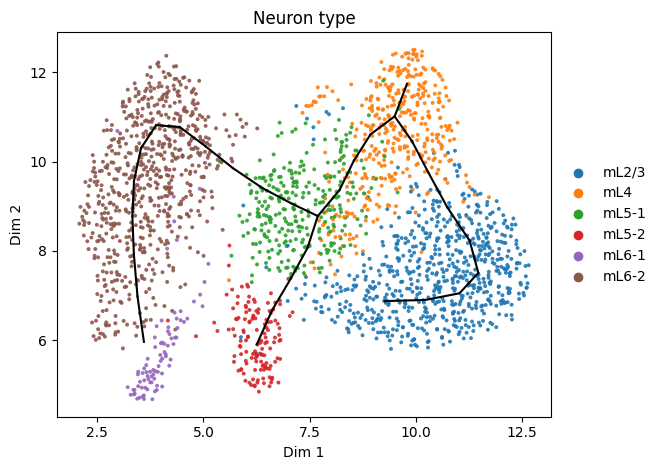

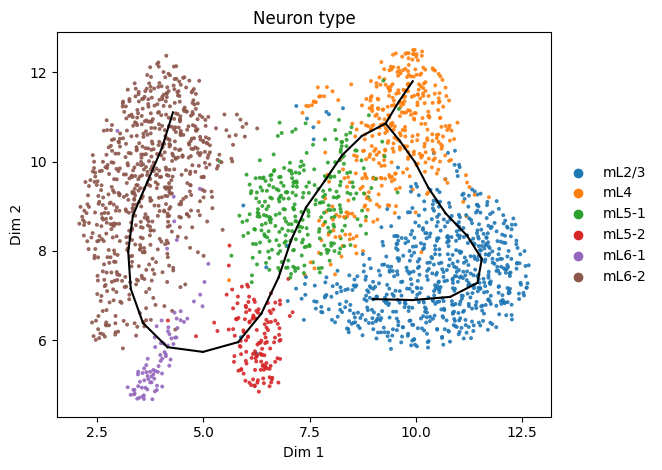

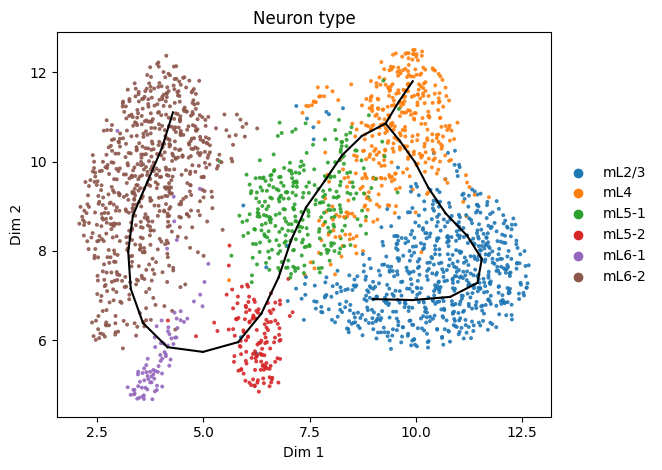

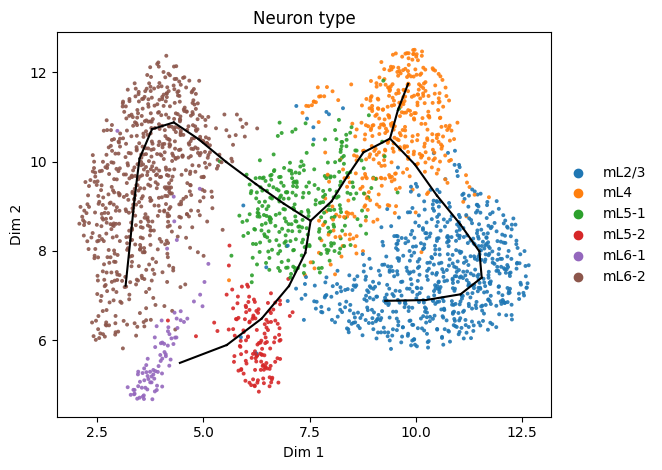

In [6]:
### USING SUPERVISION ###

st2.tl.seed_graph(adata,n_clusters=20)
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep0, seed_epg_edges0 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep0, epg_edges0 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

st2.tl.seed_graph(adata,n_clusters=20,label='Neuron type',label_strength=2, paths_favored=[['mL5-2','mL6-1']])
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep1, seed_epg_edges1 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep1, epg_edges1 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

st2.tl.seed_graph(adata,n_clusters=20,label='Neuron type',label_strength=2, paths_disfavored=[['mL5-1','mL6-2']])
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep2, seed_epg_edges2 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep2, epg_edges2 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

st2.tl.seed_graph(adata,n_clusters=20,label='Neuron type',label_strength=2, paths_disfavored=[['mL6-1','mL6-2']])
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep3, seed_epg_edges3 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep3, epg_edges3 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


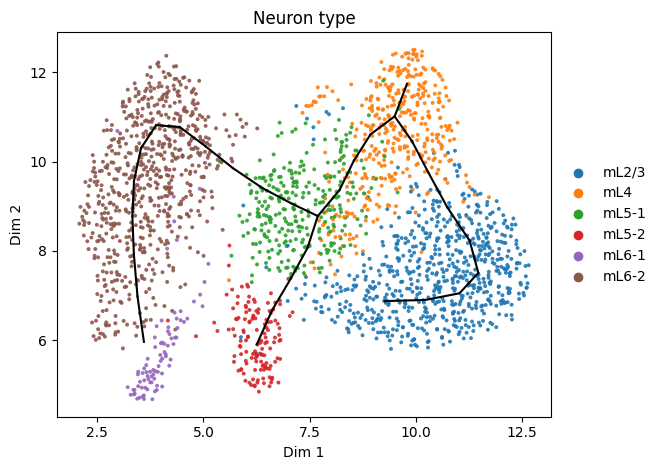

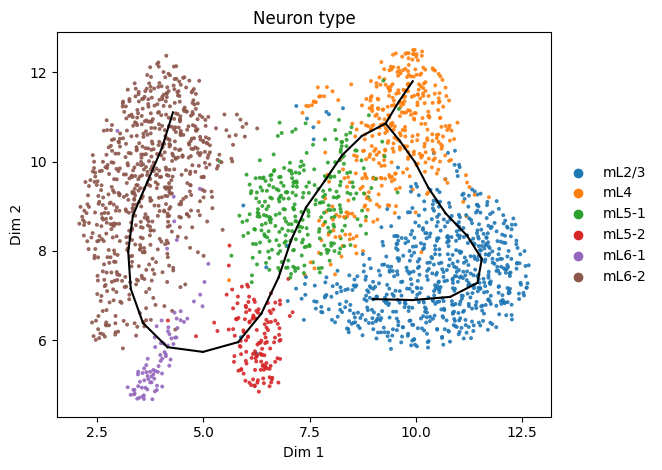

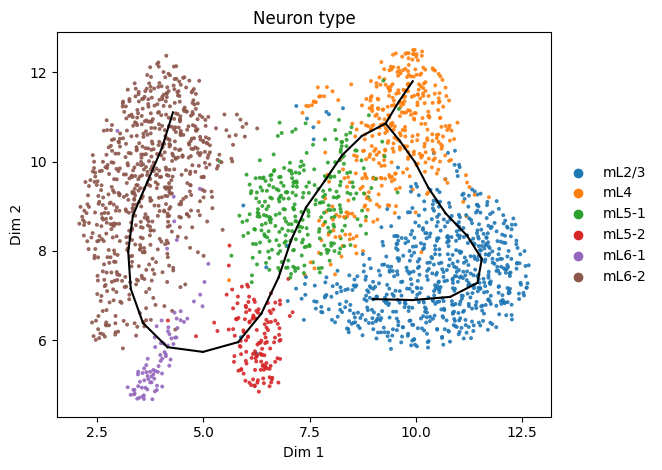

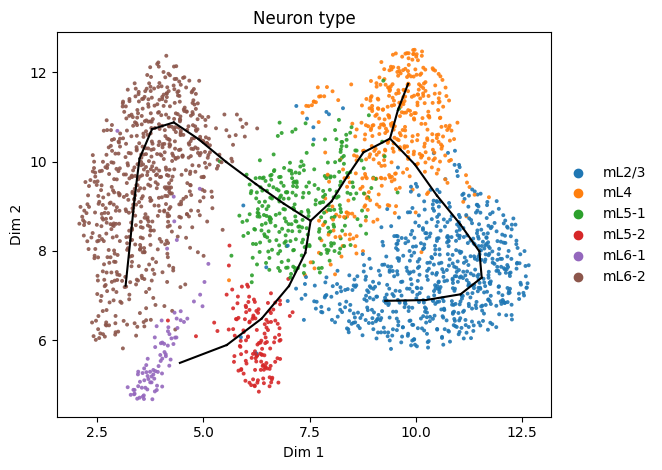

In [6]:
### USING SUPERVISION ###

st2.tl.seed_graph(adata,n_clusters=20)
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep0, seed_epg_edges0 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep0, epg_edges0 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

st2.tl.seed_graph(adata,n_clusters=20,label='Neuron type',label_strength=2, paths_favored=[['mL5-2','mL6-1']])
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep1, seed_epg_edges1 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep1, epg_edges1 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

st2.tl.seed_graph(adata,n_clusters=20,label='Neuron type',label_strength=2, paths_disfavored=[['mL5-1','mL6-2']])
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep2, seed_epg_edges2 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep2, epg_edges2 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

st2.tl.seed_graph(adata,n_clusters=20,label='Neuron type',label_strength=2, paths_disfavored=[['mL6-1','mL6-2']])
st2.tl.learn_graph(adata,n_nodes=30)
st2.pl.graph(adata,color=['Neuron type'],key='epg')
seed_epg_nodep3, seed_epg_edges3 = adata.uns['seed_epg']['node_pos'], adata.uns['seed_epg']['edge']
epg_nodep3, epg_edges3 = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

# Plots

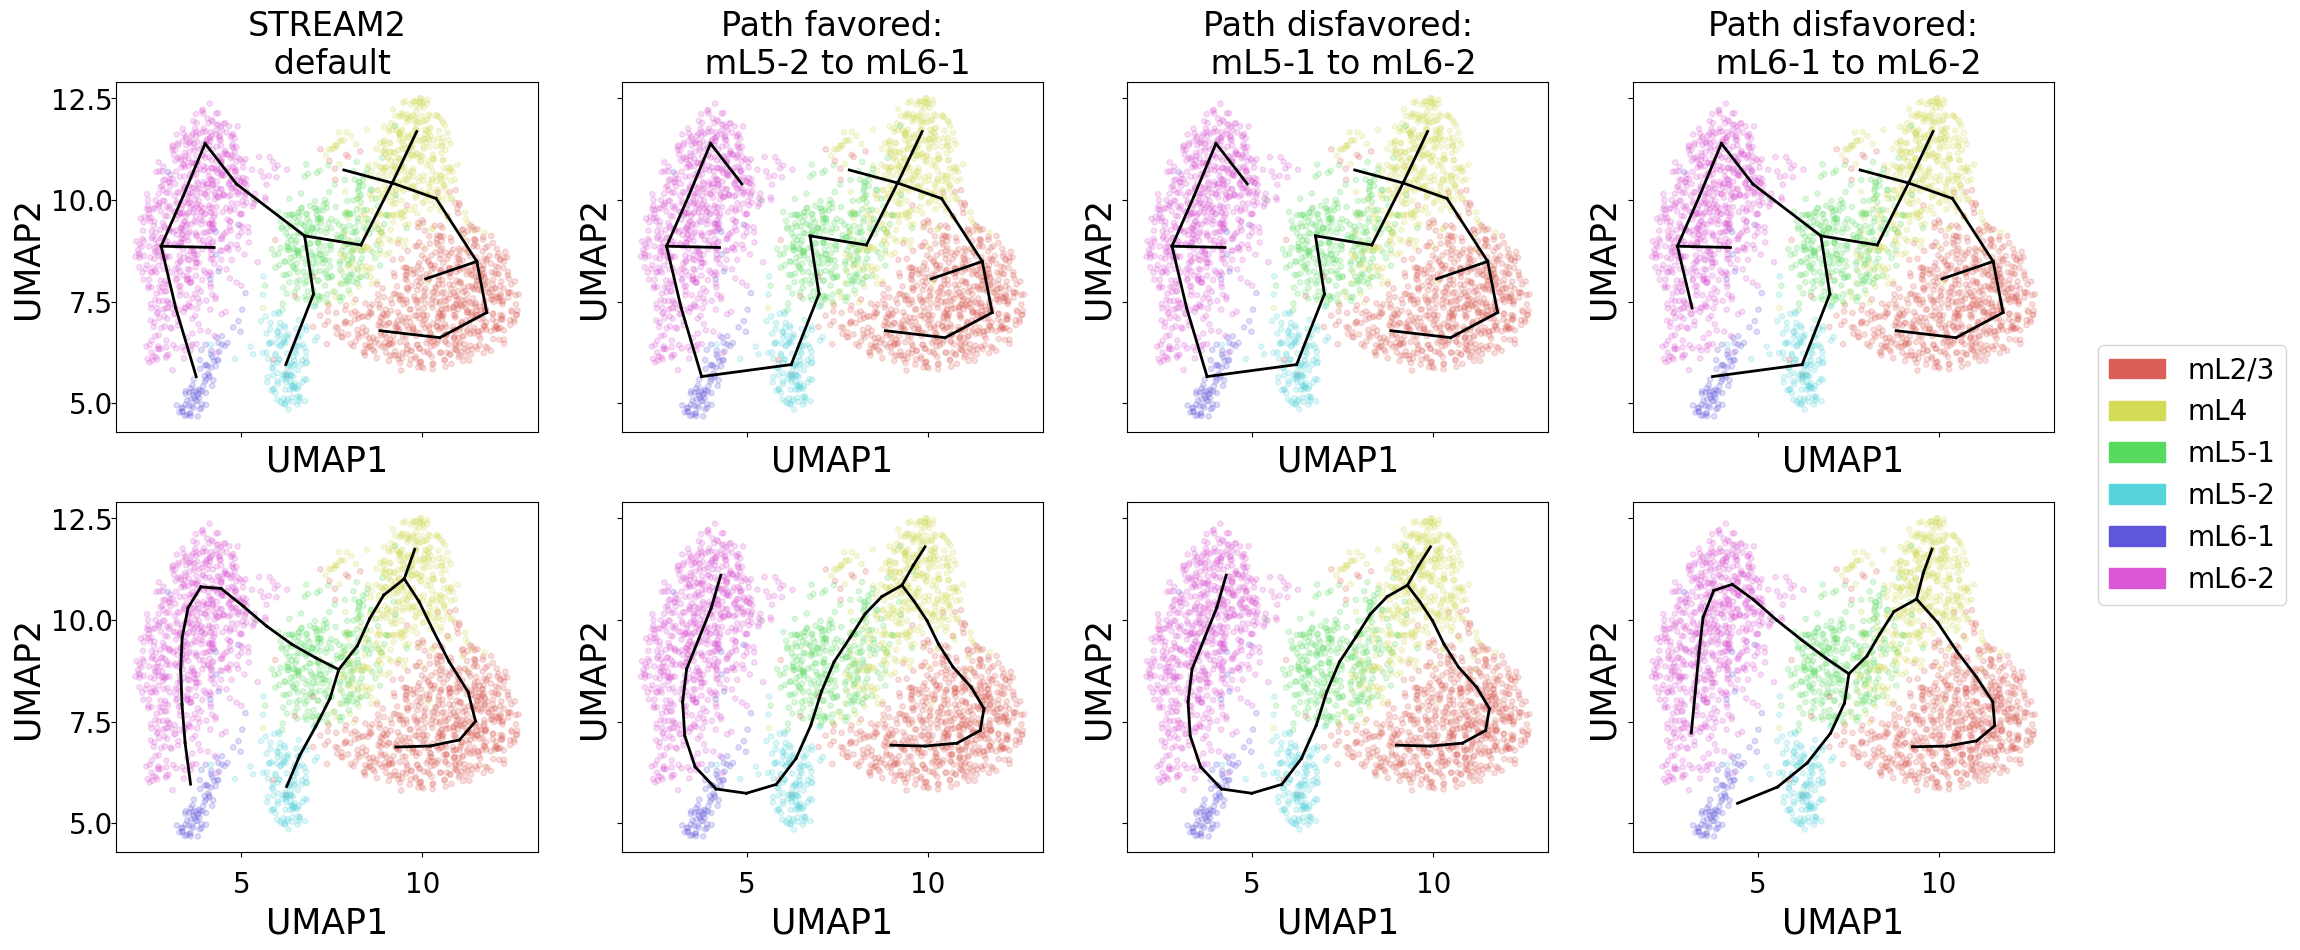

In [21]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2,4,figsize=(25,10),sharey=True,sharex=True)
axs=axs.flat
X_plot=X
linewidth=2


for i0,(d1,d2) in enumerate(((0,1),)):
    for edges,nodes,title in [(seed_epg_edges0,seed_epg_nodep0,'STREAM2\n default'),
                        (seed_epg_edges1,seed_epg_nodep1,'Path favored:\n mL5-2 to mL6-1'),
                        (seed_epg_edges2,seed_epg_nodep2,'Path disfavored:\n mL5-1 to mL6-2'),
                        (seed_epg_edges3,seed_epg_nodep3,'Path disfavored:\n mL6-1 to mL6-2'),
                        (epg_edges0,epg_nodep0,''),
                        (epg_edges1,epg_nodep1,''),
                        (epg_edges2,epg_nodep2,''),
                        (epg_edges3,epg_nodep3,'')]:
        #epg
        ax,_=init_subplot(d1,d2)
        if i0==0: ax.set_title(title)
        for edge_i in edges:
            curve_i = np.concatenate((nodes[[edge_i[0]]], nodes[[edge_i[1]]]),axis=0).T
            ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

#fig.tight_layout()
#fig.subplots_adjust(right=0.82)
fig.legend(legend, unique_labels, loc = 'center right')
plt.savefig('figures/methylation/stream_2d.png',dpi=300,bbox_inches='tight')
plt.savefig('figures/methylation/stream_2d.pdf',dpi=300,bbox_inches='tight')

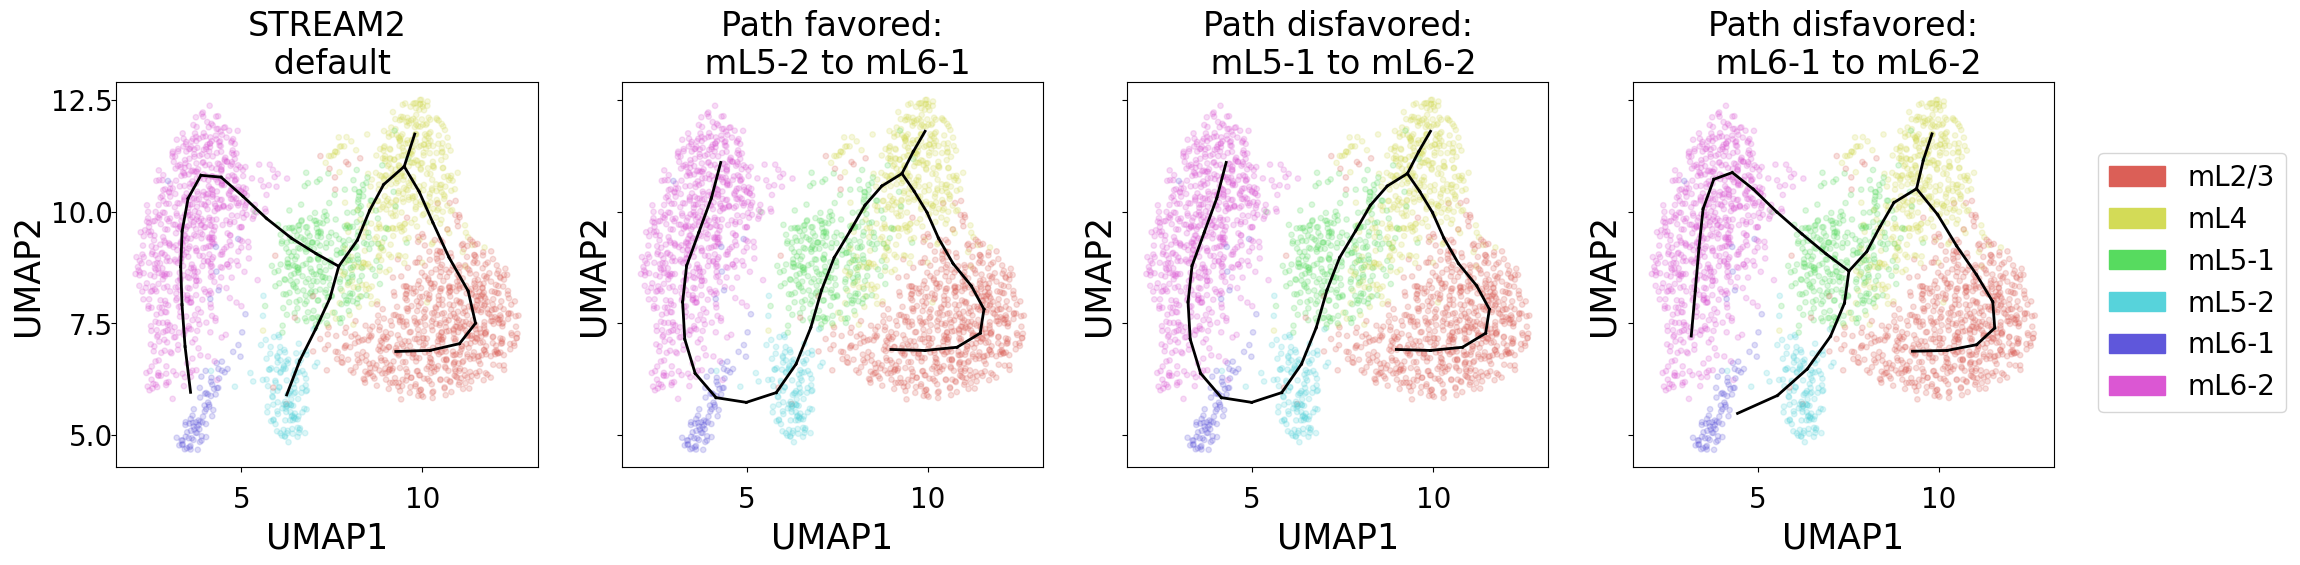

In [22]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1,4,figsize=(25,5),sharey=True,sharex=True)
axs=axs.flat
X_plot=X
linewidth=2

for i0,(d1,d2) in enumerate(((0,1),)):
    for edges,nodes,title in [
                        (epg_edges0,epg_nodep0,'STREAM2\n default'),
                        (epg_edges1,epg_nodep1,'Path favored:\n mL5-2 to mL6-1'),
                        (epg_edges2,epg_nodep2,'Path disfavored:\n mL5-1 to mL6-2'),
                        (epg_edges3,epg_nodep3,'Path disfavored:\n mL6-1 to mL6-2')]:
        #epg
        ax,_=init_subplot(d1,d2)
        if i0==0: ax.set_title(title)
        for edge_i in edges:
            curve_i = np.concatenate((nodes[[edge_i[0]]], nodes[[edge_i[1]]]),axis=0).T
            ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

#fig.tight_layout()
#fig.subplots_adjust(right=0.82)
fig.legend(legend, unique_labels, loc = 'center right')
plt.savefig('figures/methylation/stream_2d_epg_only.png',dpi=300,bbox_inches='tight')
plt.savefig('figures/methylation/stream_2d_epg_only.pdf',dpi=300,bbox_inches='tight')

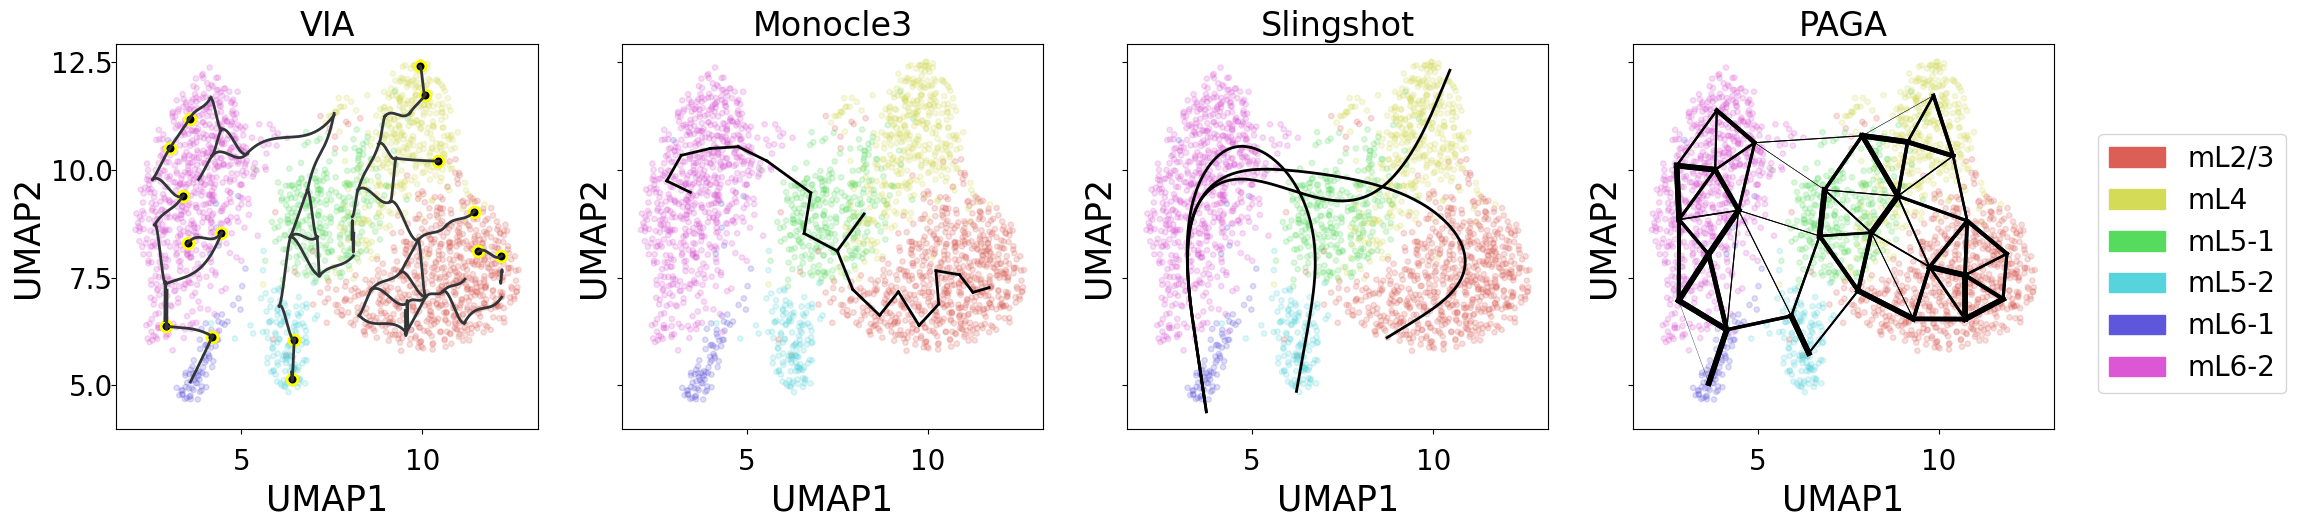

In [23]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1,4,figsize=(25,5),sharey=True,sharex=True)
axs=axs.flat
X_plot=X
linewidth=2

for i0,(d1,d2) in enumerate(((0,1),)):

    #via
    ax,_=init_subplot(d1,d2)
    if i0==0: 
        ax.set_title('VIA')
        via_plot=via_out
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci, c_edge, width_edge,  pen_color, dot_size)
    else: 
        via_plot=via_out3
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci3, c_edge3, width_edge3, pen_color3, dot_size3)
    for i in range(len(via_out)): 
        ax.plot(via_plot[i][0], via_plot[i][1], linewidth=linewidth, c='#323538')#1.5

        direction_arrow=via_plot[i][2]; head_width=via_out[i][3]
        if direction_arrow == 1:
            ax.arrow(via_plot[i][4], via_plot[i][5], via_plot[i][6], via_plot[i][7], shape='full', lw=0, length_includes_head=False,
                      head_width=.03, color='#323538')  
    count_ = 0
    for i, c_e, w, pc, dsz in zip(loci, c_edge, width_edge, pen_color, dot_size):  # sc_supercluster_nn
        ax.scatter(X[i, d1], X[i, d2], c='black', s=dsz, edgecolors=c_e, linewidth=w)
        count_ = count_ + 1

    #monocle
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Monocle3')
    for e in mcle_edges:
        curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #slingshot
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Slingshot')
    for l in slingshot_lineages['GMM']:
        curve_i = l.T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #paga
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('PAGA')
    for e,w in zip(paga_edges,paga_weights):
        curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=2*linewidth*w)


#fig.tight_layout()
#fig.subplots_adjust(right=0.82)
fig.legend(legend, unique_labels, loc = 'center right')
plt.savefig('figures/methylation/default_2d.png',dpi=300,bbox_inches='tight')
plt.savefig('figures/methylation/default_2d.pdf',dpi=300,bbox_inches='tight')